variant - 9

In [352]:
from threading import Thread
import numpy as np
from numpy.random import random as rand
from time import time
from colorama import Fore as color
import json
import os.path

In [353]:
class ThreadWithReturnValue(Thread):
	def __init__(self, target=None, args=()): Thread.__init__(self, target=target, args=args)
	def run(self): self._return = self._target(*self._args)
	def join(self): Thread.join(self); return self._return

In [354]:
def measure_time(f):
	def measure(*args): start=time(); res=f(*args); end = time(); t = end-start; return {'result': res, 'time': t}
	return measure

In [355]:
def kahan_sum(sum, c, val):
	y = val - c
	t = sum + y
	c = (t - sum) - y
	sum = t
	return sum, c

In [356]:
class Matrix:
	def __init__(self, data):
		self.data: np.ndarray = data

	def __repr__(self):
		return str(self.data)

	def __array__(self):
		return self.data

	def __add__(self, other):
		match self.data.shape, other.data.shape:
			case (int(x), int(y)), (int(z), int(w)):
				return self.add_matrix_matrix(other)
			case (int(x),), (int(y),):
				return self.add_vec_vec(other)
			case _, _:
				raise "Addition error!"

	def __sub__(self, other):
		if self.data.shape[0] != other.data.shape[0] or self.data.shape[1] != other.data.shape[1]:
			raise ValueError('Matrices must be of same dimensions to subtract.')
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] - other.data[i][j]
		return result

	def __rmul__(self, other):
		match self, other:
			case Matrix(), float(x):
				return Matrix(self.data * x)
			case _, _:
				raise "Multiplication error!"

	def __mul__(self, other):
		match self.data, other:
			case np.ndarray(shape=(int(_),)), float(x):
				return self.mul_vec_scalar(other)
			case np.ndarray(shape=(int(_), int(_))), float(x):
				return self.mul_matrix_scalar(other)
		
		match self.data.shape, other.data.shape:
			case (int(x), int(y)), (int(z), int(w)):
				return self.mul_matrix_matrix(other)
			case (int(x),), (int(y), int(z)):
				return self.mul_vec_matrix(other)
			case _, _:
				raise "Multiplication error!"

	def add_matrix_matrix(self, other):
		if self.data.shape[0] != other.data.shape[0] or self.data.shape[1] != other.data.shape[1]:
			raise ValueError('Matrices must be of same dimensions to add.')
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] + other.data[i][j]
		return result

	def add_vec_vec(self, other):
		if self.data.shape[0] != other.data.shape[0]:
			raise ValueError("Vectors must have the same length.")
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			result.data[i] = self.data[i] + other.data[i]
		return result

	def mul_matrix_matrix(self, other):
		if self.data.shape[1] != other.data.shape[0]:
			raise ValueError('The number of columns of the first matrix must be the same as the number of rows of the second matrix.')
		result = Matrix(np.zeros((self.data.shape[0], other.data.shape[1])))
		for i in range(self.data.shape[0]):
			for j in range(other.data.shape[1]):
				sum = 0.0
				c = 0.0
				for k in range(self.data.shape[1]):
					sum, c = kahan_sum(sum, c, self.data[i][k] * other.data[k][j])
				result.data[i][j] = sum
		return result

	def mul_vec_scalar(self, other):
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			result.data[i] = self.data[i] * other
		return result

	def mul_matrix_scalar(self, other):
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] * other
		return result

	def mul_vec_matrix(self, other):
		return Matrix(np.matmul(self, other))

	@classmethod
	def Min(cls, matrix) -> float:
		return np.min(matrix)

	@classmethod
	def from_ndarray(cls, arr):
		return Matrix(*arr.shape, data=arr)

	@classmethod
	def from_json(cls, json_string):
		data = json.loads(json_string)
		return Matrix(np.array(data['data']))

	def to_json(self):
		data = {'data': self.data.tolist()}
		return json.dumps(data)


In [357]:
generate_variables = lambda size: {
	**{i: Matrix(rand((size))) for i in ['B', 'D']},
	**{i: Matrix(rand((size, size))) for i in ['MC', 'MD', 'MX']},
	'b': rand()
}

In [358]:
def variable_to_json(var):
	match var:
		case float(x):
			return x
		case Matrix() as m:
			return m.to_json()

def generate_and_save_to_json(filename, matrix_sizes):
	data = []
	for size in matrix_sizes:
		data.append({k: variable_to_json(v) for k, v in generate_variables(size).items()})
	with open(filename, "w") as outfile:
		outfile.write(json.dumps(data))

In [359]:
def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False

variable_from_json = lambda x: float(x) if is_float(x) else Matrix.from_json(x) 

def read_json(filename):
	with open(filename, "r") as file:
		return file.read()

def json_to_variables(filename):
	data = json.loads(read_json(filename))

	for i in range(len(data)):
		data[i] = {k: variable_from_json(v) for k, v in data[i].items()}
	
	return data

In [360]:
def version_1():
	def calc_E(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# E = В * МС + D * min(MC)
		E = B * MC + D * Matrix.Min(MC)
		print(color.GREEN + f"E: {E}")
		return E

	def calc_MA(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# # MА = b * MD * (MC - MX) + MX * MC * b
		MA = b * MD * (MC - MX) + MX * MC * b
		print(color.GREEN + f"MA: {MA}")
		return MA

	def run_program(variables, output):
		tasks = [*map(measure_time, [calc_E, calc_MA])]
		threads = [*map(lambda f: ThreadWithReturnValue(target=f, args=(variables,)), tasks)]
		[*map(lambda t: t.start(), threads)]
		result = [*map(lambda t: t.join(), threads)]
		return result

	def run_and_measure(variables, output):
		res = measure_time(run_program)(variables, output)
		print(color.RED + f"time: {res['time']}")
		return res

	def get_work_result(input, output):
		separate_run_time_results = []
		run_time_results = []
		sizes = []
		for variables in input:
			res = run_and_measure(variables, output)
			
			out = dict(zip(['E', 'MA'], res['result']))
			output.write(str(out) + '\n')

			separate_run_time_results += [{k: v["time"] for k, v in out.items()}]
			run_time_results += [res]
			sizes += [variables['B'].data.shape[0]]
		return sizes, run_time_results, separate_run_time_results

	return get_work_result


In [361]:
def version_2():
	def calc_E(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# E = В * МС + D * min(MC)
		E = B * MC + D * Matrix.Min(MC)
		print(color.GREEN + f"E: {E}")
		return E

	def calc_MA(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# # MА = b * MD * (MC - MX) + MX * MC * b
		MA = b * MD * (MC - MX) + MX * MC * b
		print(color.GREEN + f"MA: {MA}")
		return MA

	def run_program(variables, output):
		tasks = [*map(measure_time, [calc_E, calc_MA])]
		threads = [*map(lambda f: ThreadWithReturnValue(target=f, args=(variables,)), tasks)]
		[*map(lambda t: t.start(), threads)]
		result = [*map(lambda t: t.join(), threads)]
		return result

	def run_and_measure(variables, output):
		res = measure_time(run_program)(variables, output)
		print(color.RED + f"time: {res['time']}")
		return res

	def get_work_result(input, output):
		separate_run_time_results = []
		run_time_results = []
		sizes = []
		for variables in input:
			res = run_and_measure(variables, output)
			
			out = dict(zip(['E', 'MA'], res['result']))
			output.write(str(out) + '\n')

			separate_run_time_results += [{k: v["time"] for k, v in out.items()}]
			run_time_results += [res]
			sizes += [variables['B'].data.shape[0]]
		return sizes, run_time_results, separate_run_time_results

	return get_work_result


In [362]:
import matplotlib.pyplot as plt
def visualize_work(version, input, output, ax, version_id):
	sizes, data, calc_data = version()(input, output)
	calc_E_times = [i['E'] for i in calc_data]
	calc_MA_times = [i['MA'] for i in calc_data]
	times = [row['time'] for row in data]
	
	ax[0].plot(sizes, times, label=f'Whole program run time - version {version_id}')
	ax[1].plot(sizes, calc_E_times, label=f'Calculation E time - version {version_id}')
	ax[1].plot(sizes, calc_MA_times, label=f'Calculation MA time - version {version_id}')


In [363]:
input_name = "input.json"
output_name = "output.txt"

if not os.path.isfile(input_name):
	generate_and_save_to_json(input_name, range(100, 150, 10))

open(output_name, 'w').close()

E: [26.94846577 25.3995425  26.09403168 24.61591729 24.84723861 25.52726215
 24.03443513 22.60182973 27.36032624 28.91326901 23.55597051 23.23993961
 26.25491591 26.01568631 24.23427736 26.20713872 22.98203461 24.5707661
 23.41061689 25.12402853 25.16909554 24.33262041 23.13806997 28.74122541
 23.69083551 24.93062336 24.04323155 25.23824756 23.68320628 25.01973526
 28.96092522 25.83878714 21.59347828 24.1189572  28.17109673 23.75878693
 25.71559078 27.20002094 22.27391052 22.39874094 24.62835986 24.1559643
 23.51517253 27.55722148 24.40131868 26.00028287 21.63104183 25.82014636
 26.90986149 24.33477174 23.82429219 24.73104957 27.04908213 22.4338244
 24.05771186 24.00556816 24.51707838 27.01547734 24.40123512 25.42077136
 26.16518474 23.23896333 23.71739433 24.76647398 25.22295003 24.51311439
 25.36441625 26.79749649 25.09203949 24.56504508 25.66953618 20.79932626
 25.09000776 25.11317612 25.19536322 23.66277477 25.48522761 27.12989948
 23.78351884 29.16616301 26.04425893 23.57291659 26

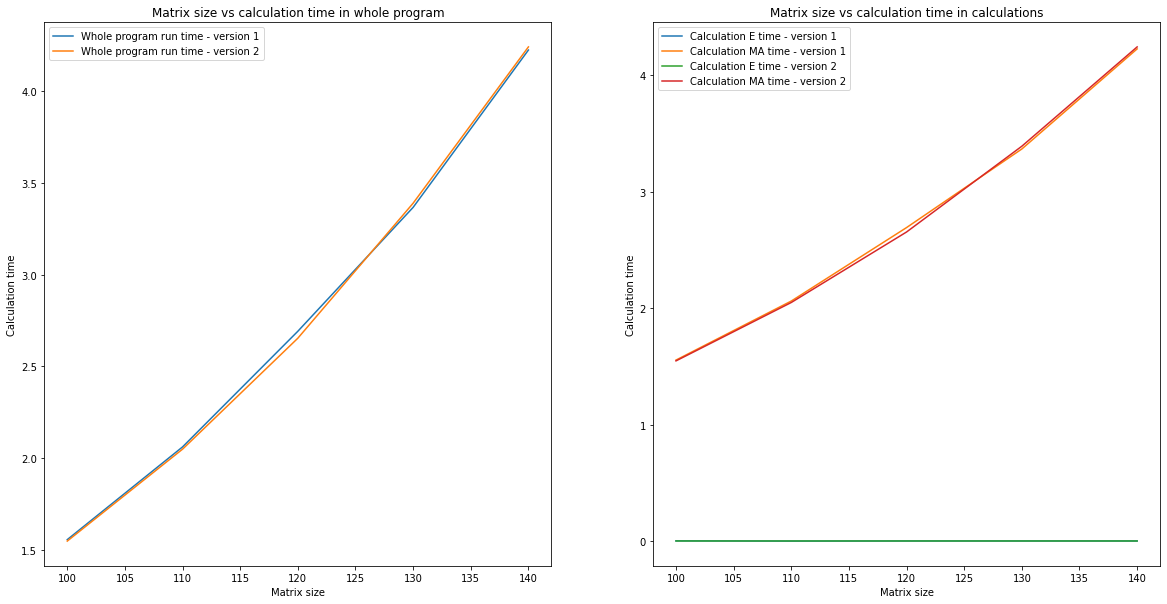

In [364]:
input = json_to_variables(input_name)

with open(output_name, 'a') as output:
	fig, ax = plt.subplots(1, 2)
	fig.set_size_inches(20, 10)
	visualize_work(version_1, input, output, ax, 1)
	visualize_work(version_2, input, output, ax, 2)

	ax[0].set_title('Matrix size vs calculation time in whole program')
	ax[1].set_title('Matrix size vs calculation time for separate calculations')

	for a in ax.tolist():
		a.set_xlabel('Matrix size')
		a.set_ylabel('Calculation time')
		a.legend()

	plt.show()
